In [ ]:
import pandas as pd
import numpy as np

# Applying functions in `pandas`
We've already seen that `pandas` enables faster computation and therefore processing of data. It is important to take advantage of this whenever possible (and it should pretty much always be possible). In the this notebook we look at how to do that.

We'll use the dataset we just cleaned to do that.

In [2]:
welly_ages = pd.read_csv("welly-ages-final.csv", index_col = 0)
welly_ages

,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_54,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_89,age_90_and_over
sa1_code,,,,,,,,,,,,,,,,,,,
7021102,15.0,0.0,6.0,9.0,9.0,18.0,21.0,15.0,6.0,6.0,12.0,6.0,6.0,6.0,3.0,6.0,0.0,3.0,0.0
7021104,9.0,9.0,9.0,6.0,9.0,6.0,18.0,9.0,9.0,12.0,3.0,3.0,3.0,9.0,3.0,3.0,3.0,3.0,0.0
7021023,12.0,9.0,12.0,15.0,15.0,9.0,12.0,12.0,18.0,12.0,9.0,9.0,9.0,9.0,3.0,3.0,3.0,3.0,0.0
7020937,3.0,6.0,6.0,24.0,18.0,9.0,3.0,3.0,12.0,9.0,27.0,18.0,9.0,12.0,9.0,6.0,3.0,3.0,0.0
7020934,12.0,9.0,12.0,9.0,6.0,18.0,21.0,15.0,9.0,12.0,18.0,21.0,15.0,12.0,12.0,6.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7034765,0.0,0.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,3.0,6.0,3.0,6.0,9.0,12.0,9.0,18.0
7034848,0.0,0.0,0.0,0.0,9.0,15.0,9.0,6.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7034920,6.0,3.0,0.0,3.0,21.0,24.0,30.0,21.0,6.0,0.0,3.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


## Summary functions applied to a `DataFrame`
Many standard statistical summary functions are provided as built-in methods by `pandas`. They return the values of the summary statistic for each column in the table as a `Series`.

In [3]:
# mean
welly_ages.mean()

age_0_4             5.978277
age_5_9             6.981897
age_10_14           7.968139
age_15_19          10.505431
age_20_24          15.160521
age_25_29          14.010130
age_30_34          12.532223
age_35_39          10.650978
age_40_44           9.792904
age_45_49           9.510500
age_50_54           9.664255
age_55_59           8.680666
age_60_64           7.322954
age_65_69           5.515568
age_70_74           4.394642
age_75_79           3.310644
age_80_84           2.028965
age_85_89           1.149167
age_90_and_over     0.671253
dtype: float64

In [4]:
# standard deviation
welly_ages.std()

age_0_4             4.330825
age_5_9             4.948030
age_10_14           5.457915
age_15_19          14.160243
age_20_24          14.544616
age_25_29          10.238639
age_30_34           7.897524
age_35_39           6.033468
age_40_44           5.439307
age_45_49           5.108185
age_50_54           5.090507
age_55_59           4.971234
age_60_64           4.407336
age_65_69           3.809305
age_70_74           3.375951
age_75_79           3.599087
age_80_84           3.863133
age_85_89           3.653197
age_90_and_over     3.460203
dtype: float64

In [5]:
# median
welly_ages.median()

age_0_4             6.0
age_5_9             6.0
age_10_14           6.0
age_15_19           9.0
age_20_24          12.0
age_25_29          12.0
age_30_34          12.0
age_35_39           9.0
age_40_44           9.0
age_45_49           9.0
age_50_54           9.0
age_55_59           9.0
age_60_64           6.0
age_65_69           6.0
age_70_74           3.0
age_75_79           3.0
age_80_84           0.0
age_85_89           0.0
age_90_and_over     0.0
dtype: float64

In [6]:
welly_ages.quantile(q = [i / 10 for i in range(1, 10)])

,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_54,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_89,age_90_and_over
0.1,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,3.0,3.0,3.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0
0.3,3.0,3.0,6.0,6.0,9.0,9.0,9.0,6.0,6.0,6.0,6.0,6.0,6.0,3.0,3.0,0.0,0.0,0.0,0.0
0.4,3.0,6.0,6.0,6.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,6.0,6.0,3.0,3.0,3.0,0.0,0.0,0.0
0.5,6.0,6.0,6.0,9.0,12.0,12.0,12.0,9.0,9.0,9.0,9.0,9.0,6.0,6.0,3.0,3.0,0.0,0.0,0.0
0.6,6.0,9.0,9.0,9.0,12.0,15.0,15.0,12.0,9.0,9.0,12.0,9.0,9.0,6.0,6.0,3.0,3.0,0.0,0.0
0.7,9.0,9.0,9.0,12.0,15.0,18.0,15.0,12.0,12.0,12.0,12.0,12.0,9.0,6.0,6.0,3.0,3.0,0.0,0.0
0.8,9.0,12.0,12.0,12.0,21.0,21.0,18.0,15.0,15.0,15.0,15.0,12.0,12.0,9.0,6.0,6.0,3.0,3.0,0.0
0.9,12.0,12.0,15.0,15.0,30.0,27.0,21.0,18.0,18.0,15.0,15.0,15.0,12.0,12.0,9.0,6.0,6.0,3.0,3.0


If you want calculation across rows then specify `axis="columns"`.

In [7]:
welly_ages.mean(axis = "columns")

sa1_code
7021102     7.736842
7021104     6.631579
7021023     9.157895
7020937     9.473684
7020934    11.210526
             ...    
7034765     4.578947
7034848     2.526316
7034920     6.631579
7034846     7.578947
7034861          NaN
Length: 1404, dtype: float64

### An overview
The `describe()` function provides a helpful overview.

In [8]:
welly_ages.describe()

,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_54,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_89,age_90_and_over
count,1381.000000,1381.000000,1381.000000,1381.000000,1383.000000,1382.000000,1381.000000,1381.000000,1381.000000,1381.000000,1382.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000
mean,5.978277,6.981897,7.968139,10.505431,15.160521,14.010130,12.532223,10.650978,9.792904,9.510500,9.664255,8.680666,7.322954,5.515568,4.394642,3.310644,2.028965,1.149167,0.671253
std,4.330825,4.948030,5.457915,14.160243,14.544616,10.238639,7.897524,6.033468,5.439307,5.108185,5.090507,4.971234,4.407336,3.809305,3.375951,3.599087,3.863133,3.653197,3.460203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.000000,6.000000,9.000000,12.000000,12.000000,12.000000,9.000000,9.000000,9.000000,9.000000,9.000000,6.000000,6.000000,3.000000,3.000000,0.000000,0.000000,0.000000
75%,9.000000,9.000000,12.000000,12.000000,18.000000,18.000000,15.000000,15.000000,12.000000,12.000000,12.000000,12.000000,9.000000,9.000000,6.000000,6.000000,3.000000,3.000000,0.000000
max,30.000000,36.000000,39.000000,231.000000,183.000000,96.000000,84.000000,45.000000,42.000000,27.000000,33.000000,27.000000,30.000000,24.000000,27.000000,63.000000,69.000000,75.000000,75.000000


There isn't very much more to say than this about the builtin functions. There are many useful functions available, although the way that the `pandas` API documentation is organised makes it a little tricky to find them all in one convenient to consult place. So here's a link to get you where you need to go: https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#descriptive-statistics.

### But wait... there are also simple graphics
Using `matplotlib` or another plotting library to view graphical summaries of data can be very useful and many basic plots are available usually via `<dataframe>.<series>.plot.some_function()`. They won't always be useful&mdash;and for these data most of them are not&mdash;but it's good to know they're there: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#basic-plotting-plot.

<Axes: title={'center': 'Population ages 20-64, by SA1'}>

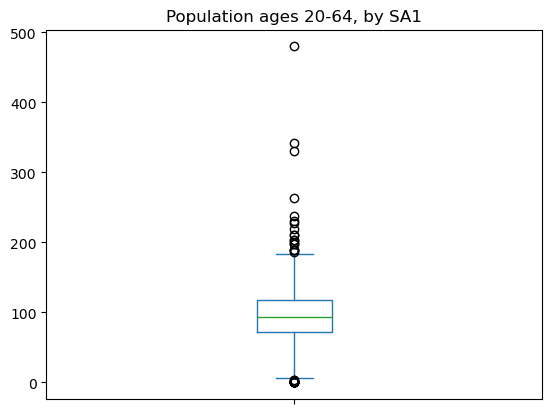

In [9]:
welly_ages.loc[:, "age_20_24":"age_60_64"] \
    .sum(axis = "columns") \
    .plot.box(title = "Population ages 20-64, by SA1")

We will spend more time on the graphics options for mapping when we look more closely at `geopandas` a little later.

## Applying functions to `DataFrame`
You aren't restricted to the built in mathematical and other functions. As an example a simple measure of the unevenness of a set of numbers is the sum of the squared fractions of the total that each value represents. The more unequal a set of numbers, the larger this calculation will be for a set of numbers of a given size. 

We could calculate this across the rows in our data table (i.e. for each SA1) in a series of steps. Like this:

In [10]:
# get row totals
welly_age_totals = welly_ages.sum(axis = "columns")
# this step is not obvious... it relies on the broadcasting rules
# see https://numpy.org/doc/stable/user/basics.broadcasting.html
# where the underlying numpy behaviour is explained (it's complicated!)
welly_age_fracs = welly_ages.divide(welly_age_totals, axis = "index") 
welly_age_fracs_squared = welly_age_fracs ** 2
welly_age_fracs_squared.sum(axis = "columns")

sa1_code
7021102    0.082882
7021104    0.073696
7021023    0.066587
7020937    0.083889
7020934    0.066852
             ...   
7034765    0.103448
7034848    0.203125
7034920    0.157596
7034846    0.194444
7034861    0.000000
Length: 1404, dtype: float64

BUT... I'm not even going to pretend much of the above is obvious. Especially step 2 where we have to know about _broadcasting_ to understand how dividing the whole table by the row totals will behave. I had to look this step up, and I doubt that I will ever be certain what will happen in this situation until I try it. 

In practice, instead of the above I make make a function to perform the required calculation on a set of values. Here's that function:

In [11]:
def unevenness(values):
    total = np.sum(values)
    if total == 0:
        return 0
    return np.sum([(x / total) ** 2 for x in values])

# and to show it works
print(f"""
      {unevenness([20, 20, 20, 20,  20]) = :.3f}
      {unevenness([ 7, 14, 21, 28,  35]) = :.3f} 
      {unevenness([ 5,  5, 20, 30,  40]) = :.3f}
      {unevenness([ 2,  2,  2,  2,  92]) = :.3f}
      {unevenness([ 0,  0,  0,  0, 100]) = :.3f}
      """)


      unevenness([20, 20, 20, 20,  20]) = 0.200
      unevenness([ 7, 14, 21, 28,  35]) = 0.244 
      unevenness([ 5,  5, 20, 30,  40]) = 0.295
      unevenness([ 2,  2,  2,  2,  92]) = 0.848
      unevenness([ 0,  0,  0,  0, 100]) = 1.000
      


The equally split first set of values has the lowest unevenness of these five sets of five numbers, where the last set of values has the highest (all values are 0 except for one).

Of note here is that we use `numpy` mathematics functions not base Python `math` functions because they are faster. It probably doesn't matter very much here, but this is a good habit to get into, because when it does matter it will matter a lot!

Having written such a function, we can use `apply()` to uh... _appply_ it to rows or columns in a data table. Because my function does not deal with NA values, and the data table still contains NA values we drop those before applying the function.

In [12]:
welly_ages.iloc[:, :-1] \
    .dropna() \
    .apply(unevenness, axis = "columns")

sa1_code
7021102    0.082882
7021104    0.073696
7021023    0.066587
7020937    0.083889
7020934    0.066852
             ...   
7034887    0.114687
7034765    0.096408
7034848    0.203125
7034920    0.157596
7034846    0.194444
Length: 1381, dtype: float64

`apply` allows for the usual specification of the `axis` whether (i.e. `axis = "index"` or `axis = "columns"`), so it's a simple matter to apply this to each column in the data rather than across rows. This is an advantage of this approach over an attempt to perform this calculation as a series of data table processing steps, where you may have to change the `axis` parameter in several steps of the process.

In [13]:
welly_ages \
    .dropna() \
    .apply(unevenness, axis = "index")

age_0_4            0.001104
age_5_9            0.001088
age_10_14          0.001064
age_15_19          0.002039
age_20_24          0.001390
age_25_29          0.001111
age_30_34          0.001011
age_35_39          0.000956
age_40_44          0.000947
age_45_49          0.000933
age_50_54          0.000925
age_55_59          0.000961
age_60_64          0.000986
age_65_69          0.001069
age_70_74          0.001151
age_75_79          0.001579
age_80_84          0.003347
age_85_89          0.008037
age_90_and_over    0.019952
dtype: float64